### Notebook Description
This notebook is for using the extracted endmembers to perform telluric correction on new observations. The notebook serves as a way to validate extracted components by inspecting how well they can correct telluric lines.  

The notebook is set up to enable correction of multible observations.

If one wishes to perform correction on other spectra then either use the correction function from correction.py or load them into this notebook and run the corrections.

The notebook contains the following steps:
 1. Load packages and observations to correct (either a single observation or multiple observations)
 2. Fit the weights of the autoencoder telluric spectrum to the observations.
 3. Use fitted telluric spectra to perform corrections of the observations and inspect the results.

In [1]:
#Importing Packages
from scipy import interpolate
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.spatial import distance
from scipy import optimize
import pickle
import os
from continuum_normalisation import continuum_normalize
from optimiztion import opt
from optimiztion import opt_O2
from optimiztion import error
import time
from correction import telluric_fit
%matplotlib inline

### 1. Loading Flux and Wave Files
Load them in a way appropriate for the data at hand. The observed flux, wave and blaze files need to be loaded. The wavelength axis must be in units Angstrom (Å) in air in observatory restframe.

If observations are already blaze corrected then no need for the blaze funtion. The blaze corrections are only used for fitting the telluric weights. The output telluric spectra can still be used to correct non-blaze corrected observations.



#### Example of loading single spectrum
Here the validation observation from the paper plots is loaded. 

In [2]:
# Loading Validation observtion
fn  = '../validation_spectrum/HARPN.2020-11-03T10-18-23.184_e2ds_A.fits'
wv  = '../validation_spectrum/HARPN.2020-11-03T07-29-05.596_wave_A.fits'
blz = '../validation_spectrum/HARPN.2020-11-03T07-06-51.587_blaze_A.fits'

# Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
file_name = []
wave_name = []
blaze_name = []

flux, header = fits.getdata(fn, header=True)
wave, header = fits.getdata(wv, header=True)
blaze, header = fits.getdata(blz, header=True)

flux_obs_load.append(flux)
wave_obs_load.append(wave)
blaze_obs_load.append(blaze)      

file_name.append(fn)
wave_name.append(wv)
blaze_name.append(blz)     

flux_obs_load = np.asarray(flux_obs_load)
wave_obs_load = np.asarray(wave_obs_load)
blaze_obs_load = np.asarray(blaze_obs_load)

flux_obs_load=flux_obs_load/blaze_obs_load

In [3]:
print(flux_obs_load.shape, wave_obs_load.shape, blaze_obs_load.shape)

(1, 69, 4096) (1, 69, 4096) (1, 69, 4096)


#### Example of loading multiple spectra

In [3]:
## Initializing Arrays
#flux_obs_load  = []
#wave_obs_load  = []
#blaze_obs_load = []
#bary_obs_load = []
#file_name = []
#wave_name = []
#blaze_name = []

#for path, sub, files in os.walk('../validation_spectrum/sun_download_2015'):
#    for name in files:
#        if name.endswith("S2D_A.fits"):
#            fn = path+'/'+name
#            flux = fits.getdata(fn,1) # flux corrected from blaze
#            wave = fits.getdata(fn,5)  # wavelength solution in the air
#            header = fits.getheader(fn)
#            bary = header['HIERARCH TNG QC BERV']
#            flux_obs_load.append(flux)
#            wave_obs_load.append(wave)
#            bary_obs_load.append(bary)
#            file_name.append(fn)

#bary_obs_load = np.asarray(bary_obs_load)
#flux_obs_load = np.asarray(flux_obs_load)
#wave_obs_load = np.asarray(wave_obs_load)

# Using BERV to get same wl as AE_tellurics 
# Light speed in km/s
#c = 299792.458
#v=-bary_obs_load

#for i in range(len(v)):
#    wave_obs_load[i] = wave_obs_load[i] * (1.0 + v[i] / c)    

#print('Done Loading')

Done Loading


### 2. Fitting the telluric spectrum

The telluric_fit function is used to fit the telluric spectrum of the observations. The output is the fitted telluric spectrum along with the weights of the H2O and O2 components.


Input spectra should not be continuum normalized. Input spectra should be blaze corrected.

In [4]:
telluric_spec,H2O_weights,O2_weights =  telluric_fit(flux_obs_load,wave_obs_load)

Initializing (~ 10 sec)...



/home/m.gorsini/telluric-autoencoder/code/optimiztion.py:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  ntop = trial.suggest_uniform('ntop', 0.1, 4)   # sigma top for continuum normalization
/home/m.gorsini/telluric-autoencoder/code/optimiztion.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nbins = trial.suggest_uniform('nbins', 0.1, 4) # sigma bottom for continuum normalization
/home/m.gorsini/telluric-autoencoder/code/optimiztion.py:82: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  H2O_weight = trial.suggest_uniform('H2O_weight', 0, 2)
/home/m.gorsini/te

Correcting observation 1/1

Initialization performed in 9.031 seconds

1 correction(s) performed in 0.1023 seconds

Total time is 9.1333 seconds
Finished



### 3. Plot result

Corrections can now be performed by dividing the observed spectra with their corresponding fitted telluric spectra. Here it is shown for the correction of the validation observation:

*HARPN.2020-11-03T10-18-23.184_e2ds_A.fits*

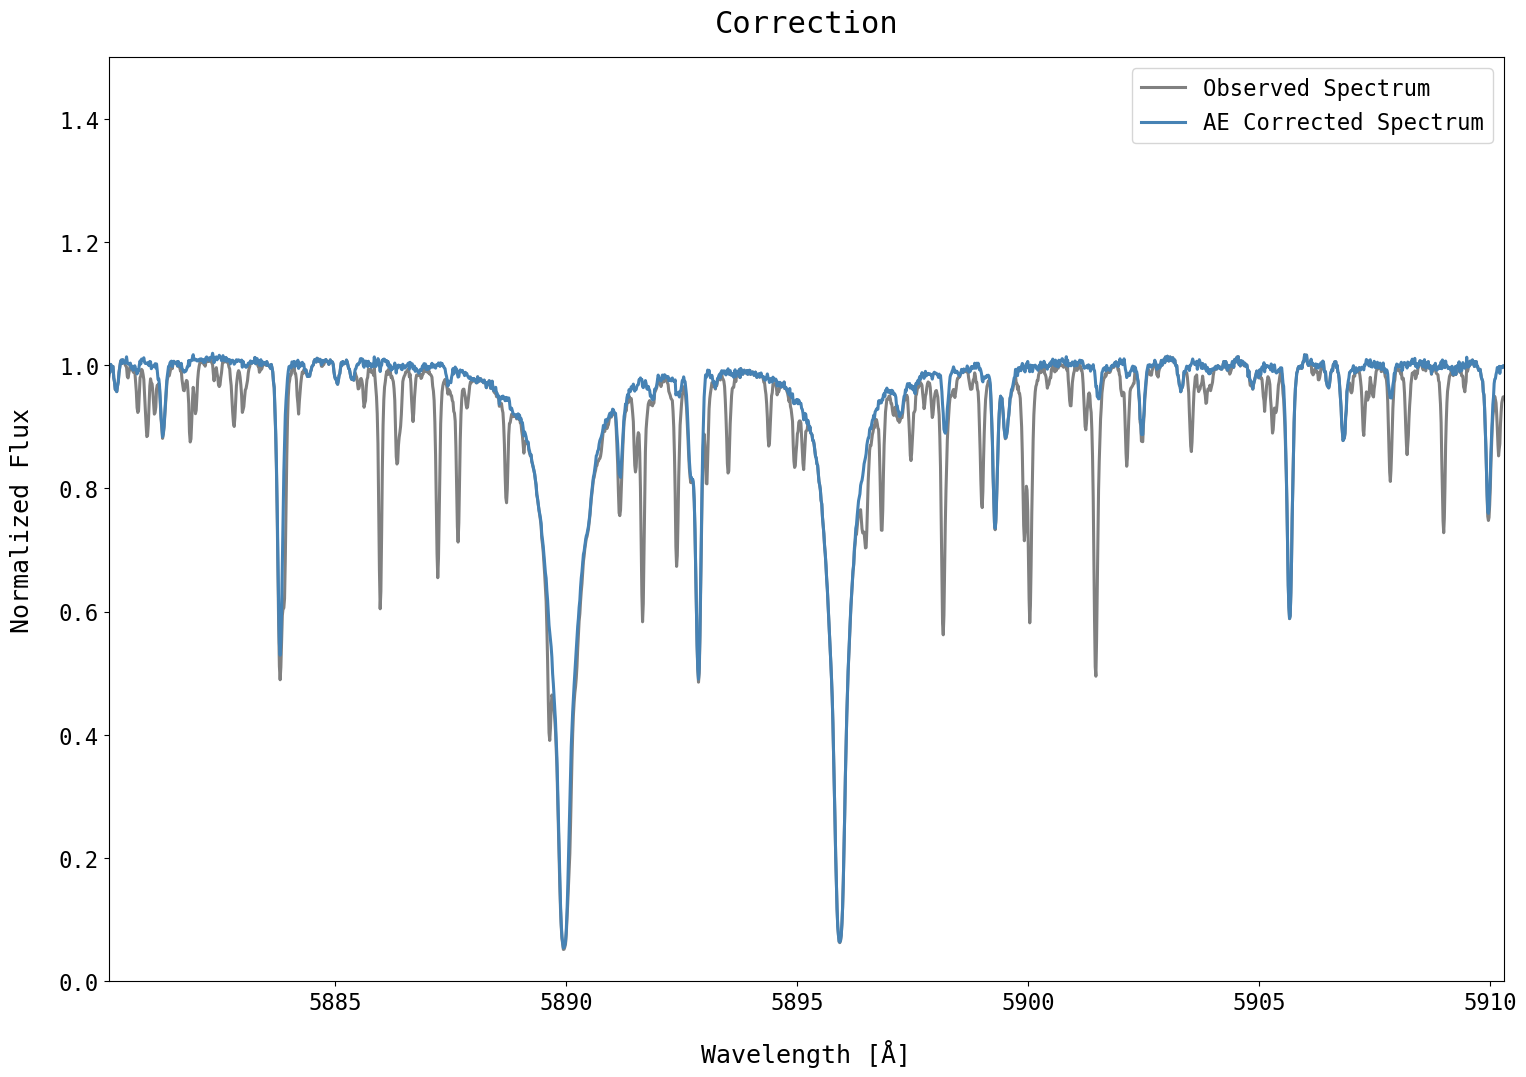

In [5]:
obs_nr=0
order=53
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(18,12))
linewidth=2.2

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order]#/blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
plt.axis([5880.1,5910.3,0,1.5]) # 53
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);

### Molecfit 

Loading a full Molecfit correction of the validation observation to compare. 

A molecfit correction has only been computed for the validation observation:

*HARPN.2020-11-03T10-18-23.184_e2ds_A.fits*

so the comparison here does not work if other spectra are corrected.

In [7]:
# from 1d version
output = fits.getdata('../molecfit/solar_h2o_o2_5_g3p0l1p5_v0_k300_wl2_cont3_box0_tac.fits')

wl = output['lambda'] # original vacuum wl
fl = output['flux'] # original flux
cfl = output['cflux'] # corrected flux
wl_tel = output['mlambda'] # model telluric wl
trans_tel = output['mtrans'] # model telluric transmission spectrum

# Vac2Air conversion
def vac2air(wl_vac):
    """
    Convert wl from vacuum to air
 
    Parameters
    ----------
    wl_vac : array
        wl in vacuum, in Å.
 
    Returns
    -------
    wl_air : array
        wl in air, in Å.
 
    """
    sigma2 = (1E4/wl_vac)**2
    fact = 1 + 5.792105E-2/(238.0185 - sigma2) + 1.67917E-3/(57.362 - sigma2)
    wl_air = wl_vac * (1/fact)
    return wl_air
                                                                  
                                                                  
# Converting molect from vacuum to air
mol_wave=vac2air(wl*10000)  
mol_combined = trans_tel

wave_obs = wave_obs_load[0]
n_apertures = flux_obs_load.shape[1] # Number of apertures in training data
P = flux_obs_load.shape[2] # Pixels in each aperture

# Interpolating molecfitspectra to observed spectrum in each aperture
mol_interpolated = np.zeros([n_apertures,P])
for i in range(0,n_apertures): 
    f = interpolate.interp1d(mol_wave, mol_combined,bounds_error=False,fill_value=np.nan,kind='quadratic')
    mol_interpolated[i]  = f(wave_obs[i])

### Plotting the comparison

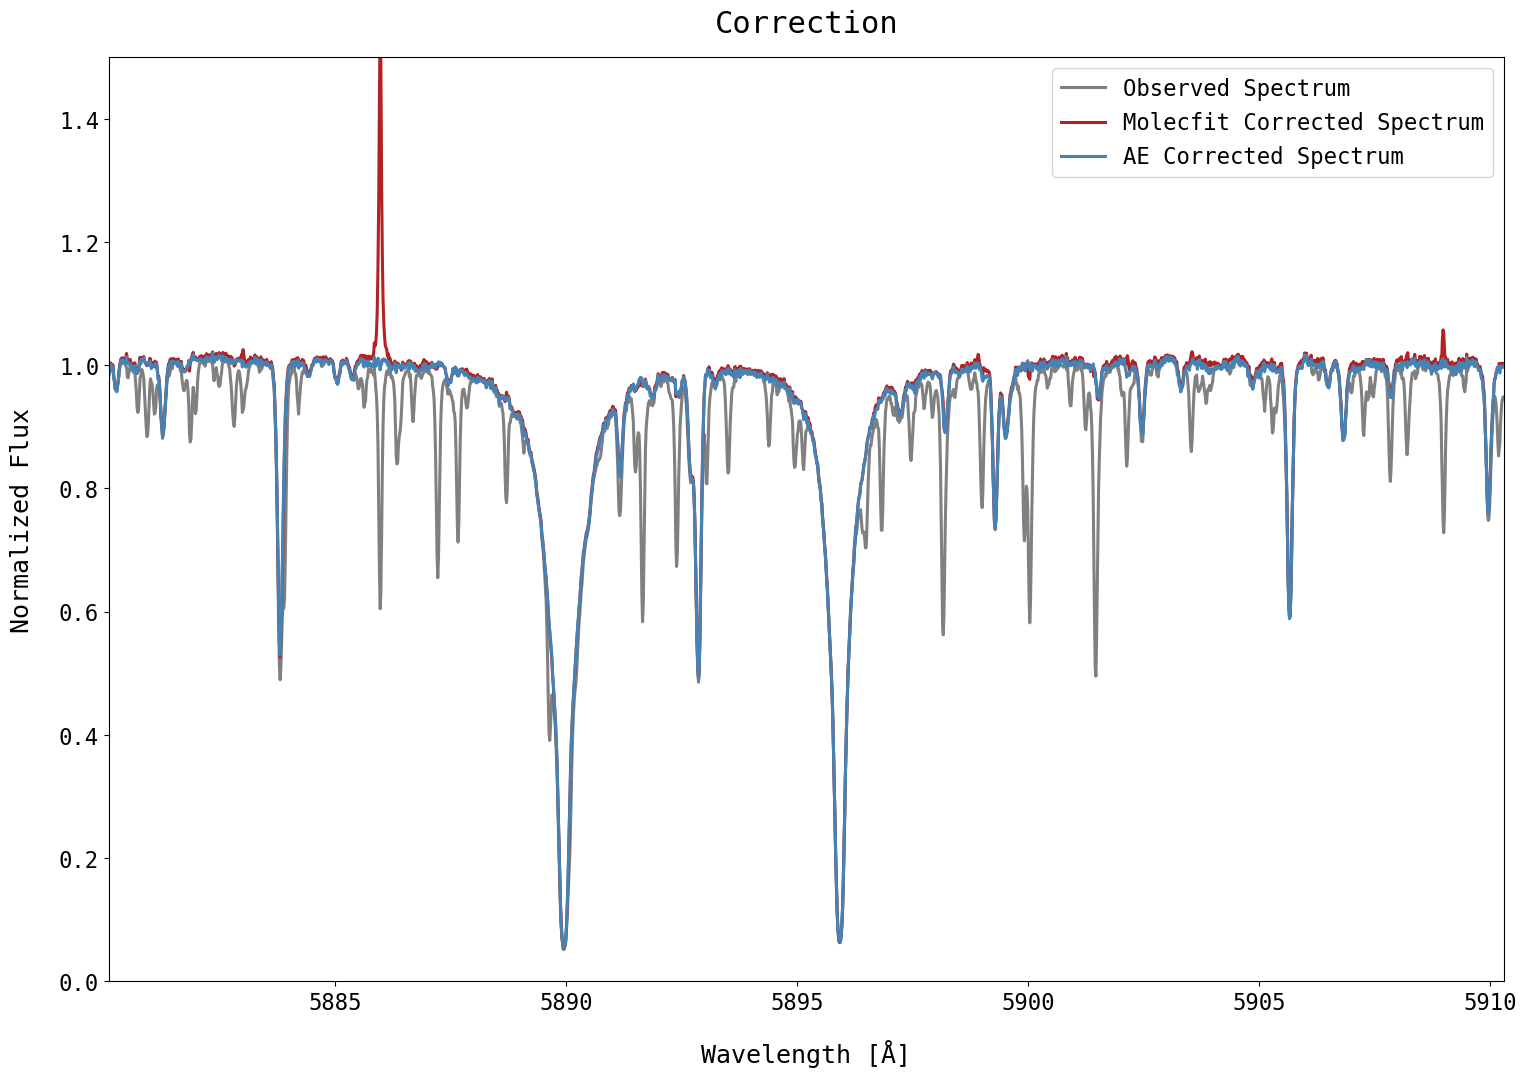

In [8]:
# Select observation and aperture (order) to show comparison for. 
obs_nr=0
order=53 # Check for example aperture 53 or 64 for strong H2O tellurics.

font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(18,12))
linewidth=2.2
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
obs = flux_obs_load[obs_nr,order]#/blaze_obs_load[obs_nr,order]

plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/mol_interpolated[order]/cont,color='firebrick',label='Molecfit Corrected Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)

if order ==53:
    plt.axis([5880.1,5910.3,0,1.5]) # 53
    
if order == 64:
    plt.axis([6540,6583,0.15,1.12])  # 64
    
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);